This is a mini-project using naive Bayes for defect classification.


In [285]:
# Here we assume feature independence, continous features being normally distributed, discrete features having multinomial distributions, and all features are equally important.
# imports needed for this notebook
import numpy as np
import pandas as pd
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectFromModel
from sklearn.metrics import confusion_matrix, f1_score, recall_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier





In [286]:
# Load dataset as df
df = pd.read_csv("/Users/E1012131/Downloads/Industrial_fault_detection.csv") 
df = df.dropna()  # Drop rows with missing values
NaN = ['FFT_Temp_0', 'FFT_Vib_0', 'FFT_Pres_0', 'FFT_Temp_1',
       'FFT_Vib_1', 'FFT_Pres_1', 'FFT_Temp_2', 'FFT_Vib_2', 'FFT_Pres_2',
       'FFT_Temp_3', 'FFT_Vib_3', 'FFT_Pres_3', 'FFT_Temp_4', 'FFT_Vib_4',
       'FFT_Pres_4', 'FFT_Temp_5', 'FFT_Vib_5', 'FFT_Pres_5', 'FFT_Temp_6',
       'FFT_Vib_6', 'FFT_Pres_6', 'FFT_Temp_7', 'FFT_Vib_7', 'FFT_Pres_7',
       'FFT_Temp_8', 'FFT_Vib_8', 'FFT_Pres_8', 'FFT_Temp_9', 'FFT_Vib_9',
       'FFT_Pres_9']
df = df_filtered = df[(df[NaN] != 0).any(axis=1)]
print(df.info())
columns = df.columns
print(columns)
print(df['Fault_Type'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 990 entries, 0 to 989
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  990 non-null    float64
 1   Vibration    990 non-null    float64
 2   Pressure     990 non-null    float64
 3   Flow_Rate    990 non-null    float64
 4   Current      990 non-null    float64
 5   Voltage      990 non-null    float64
 6   FFT_Temp_0   990 non-null    float64
 7   FFT_Vib_0    990 non-null    float64
 8   FFT_Pres_0   990 non-null    float64
 9   FFT_Temp_1   990 non-null    float64
 10  FFT_Vib_1    990 non-null    float64
 11  FFT_Pres_1   990 non-null    float64
 12  FFT_Temp_2   990 non-null    float64
 13  FFT_Vib_2    990 non-null    float64
 14  FFT_Pres_2   990 non-null    float64
 15  FFT_Temp_3   990 non-null    float64
 16  FFT_Vib_3    990 non-null    float64
 17  FFT_Pres_3   990 non-null    float64
 18  FFT_Temp_4   990 non-null    float64
 19  FFT_Vib_4    

This loaded dataset is unbalanced as shown in the printed class counts. Therefore, boostrapping would be done to balance the dataset creating a balance through the class counts

In [287]:
# split df into test and train sets
X = df.drop(['Fault_Type'], axis=1)
y = df['Fault_Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.head())
print(y_train.value_counts())

     Temperature  Vibration    Pressure  Flow_Rate    Current     Voltage  \
312    78.825500   3.275111  105.736564  14.172094  16.484117  211.949048   
129    72.547778   3.025363  106.011962   9.177014  19.968625  220.978272   
159    74.751486   3.270091  101.313333  10.626369  15.252505  208.698213   
888    77.744477   2.967245  102.002628  10.286098  15.682488  197.339479   
547    74.344292   3.176519  103.200789  12.933082  14.827828  224.689781   

     FFT_Temp_0  FFT_Vib_0   FFT_Pres_0  FFT_Temp_1  ...  FFT_Pres_6  \
312  771.116356  29.533028  1015.969938   12.630839  ...   15.349109   
129  738.822126  32.209240  1019.250804   11.649789  ...   28.716848   
159  773.282459  31.218497   995.940999   10.155950  ...   33.544948   
888  786.367747  30.199948  1030.673516   10.358316  ...   92.995311   
547  751.776751  30.670293   983.703123    9.980866  ...   40.900660   

     FFT_Temp_7  FFT_Vib_7  FFT_Pres_7  FFT_Temp_8  FFT_Vib_8  FFT_Pres_8  \
312    1.642440   0.254927 

In [288]:
# bootstrap majority and minority classes of the training set to balance the dataset
df_train = pd.concat([X_train, y_train], axis=1)
zero_class = df_train[df_train['Fault_Type'] == 0]
one_class = df_train[df_train['Fault_Type'] == 1]
two_class = df_train[df_train['Fault_Type'] == 2]
three_class = df_train[df_train['Fault_Type'] == 3]

target_size = max(len(zero_class), len(one_class), len(two_class), len(three_class)) + 20

zero_boostrapped = resample(zero_class,
                                replace=True,
                                n_samples=target_size,
                                random_state=42)

one_boostrapped = resample(one_class,
                                replace=True,
                                n_samples=target_size,
                                random_state=42)

two_boostrapped = resample(two_class,
                                replace=True,  
                                n_samples=target_size,
                                random_state=42)

three_bootstrapped = resample(three_class,
                                replace=True,
                                n_samples=target_size,
                                random_state=42)

df_balanced = pd.concat([zero_boostrapped, one_boostrapped, two_boostrapped, three_bootstrapped])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
X_train = df_balanced.drop('Fault_Type', axis=1)  
y_train = df_balanced['Fault_Type']


smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
X_train = X_train_res
y_train = y_train_res

print(X_train.head())
print(df_balanced.describe())
print("Class distribution after balancing:")
print(y_train.value_counts())

   Temperature  Vibration    Pressure  Flow_Rate    Current     Voltage  \
0    72.015258   3.133210   96.066409   8.950675   7.125549  222.431347   
1    78.386498   3.566811  100.247712   9.137749  14.311853  229.386400   
2    71.687461   3.290529   97.951105  10.356953  11.741621  222.022804   
3    76.677834   3.239154   99.953721   9.697402  22.030962  202.017853   
4    72.983544   3.370808   94.987105  12.307801  17.350769  204.006052   

   FFT_Temp_0  FFT_Vib_0   FFT_Pres_0  FFT_Temp_1  ...  FFT_Pres_6  \
0  749.712692  31.437999  1005.308959    9.108146  ...   29.274028   
1  775.583900  31.929405  1032.220212    7.626881  ...    2.231613   
2  736.027950  29.464534  1014.121081   30.133983  ...   29.826370   
3  752.833978  31.023305   998.525300   11.406090  ...   28.056876   
4  738.556190  31.264080   989.229319   10.536737  ...   33.553190   

   FFT_Temp_7  FFT_Vib_7  FFT_Pres_7  FFT_Temp_8  FFT_Vib_8  FFT_Pres_8  \
0   12.474013   0.942234   35.368559   19.935641   0.

The dataset is then balanced. Next step is to choose which features of the dataset are useful for the result.

In [289]:
def correlation_ratio(categories, measurements):
    categories = np.array(categories)
    measurements = np.array(measurements, dtype=float)
    cats, inv = np.unique(categories, return_inverse=True)
    y_mean = np.nanmean(measurements)
    ss_between = sum(
        (measurements[inv == i].size * (np.nanmean(measurements[inv == i]) - y_mean) ** 2)
        for i in range(len(cats))
    )
    ss_total = np.nansum((measurements - y_mean) ** 2)
    return 0.0 if ss_total == 0 else ss_between / ss_total



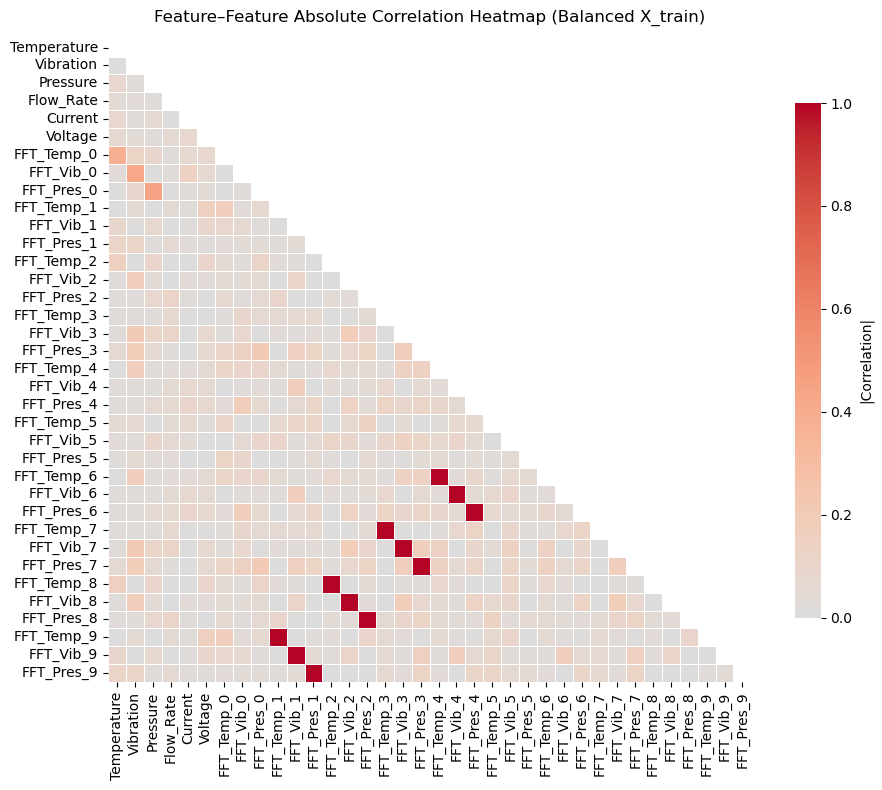

Top redundant pairs:
 FFT_Vib_4    FFT_Vib_6     1.000000
FFT_Pres_4   FFT_Pres_6    1.000000
FFT_Vib_3    FFT_Vib_7     1.000000
FFT_Pres_3   FFT_Pres_7    1.000000
FFT_Temp_4   FFT_Temp_6    1.000000
FFT_Pres_1   FFT_Pres_9    1.000000
FFT_Pres_2   FFT_Pres_8    1.000000
FFT_Temp_2   FFT_Temp_8    1.000000
FFT_Vib_2    FFT_Vib_8     1.000000
FFT_Temp_3   FFT_Temp_7    1.000000
FFT_Vib_1    FFT_Vib_9     1.000000
FFT_Temp_1   FFT_Temp_9    1.000000
Pressure     FFT_Pres_0    0.446325
Vibration    FFT_Vib_0     0.429318
Temperature  FFT_Temp_0    0.390224
FFT_Pres_0   FFT_Pres_3    0.205492
             FFT_Pres_7    0.205492
Vibration    FFT_Vib_3     0.204896
             FFT_Vib_7     0.204896
             FFT_Pres_7    0.181230
Name: |corr|, dtype: float64


In [290]:
# Keep numeric features only
X_num = X_train.select_dtypes(include=[np.number]).copy()

# Absolute Pearson correlation
corr_abs = X_num.corr().abs()

# Plot triangular heatmap
mask = np.triu(np.ones_like(corr_abs, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_abs, mask=mask, cmap='coolwarm', vmin=0, vmax=1, center=0,
    linewidths=0.5, square=True,
    cbar_kws={'shrink': 0.8, 'label': '|Correlation|'}
)
plt.title('Feature–Feature Absolute Correlation Heatmap (Balanced X_train)', pad=12)
plt.tight_layout()
plt.show()

# List top redundant pairs
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))
pairs = upper.stack().rename('|corr|').sort_values(ascending=False)
print("Top redundant pairs:\n", pairs.head(20))


In [291]:
threshold = 0.95
to_drop = [col for col in upper.columns if any(upper[col] >= threshold)]
print(f"Dropping {len(to_drop)} redundant features (|ρ|≥{threshold}):", to_drop)

X_train_red = X_num.drop(columns=to_drop)  # training-only decision

# IMPORTANT: Apply the SAME drop to the test set later
# X_test_red = X_test.select_dtypes(include=[np.number]).drop(columns=to_dr


Dropping 12 redundant features (|ρ|≥0.95): ['FFT_Temp_6', 'FFT_Vib_6', 'FFT_Pres_6', 'FFT_Temp_7', 'FFT_Vib_7', 'FFT_Pres_7', 'FFT_Temp_8', 'FFT_Vib_8', 'FFT_Pres_8', 'FFT_Temp_9', 'FFT_Vib_9', 'FFT_Pres_9']


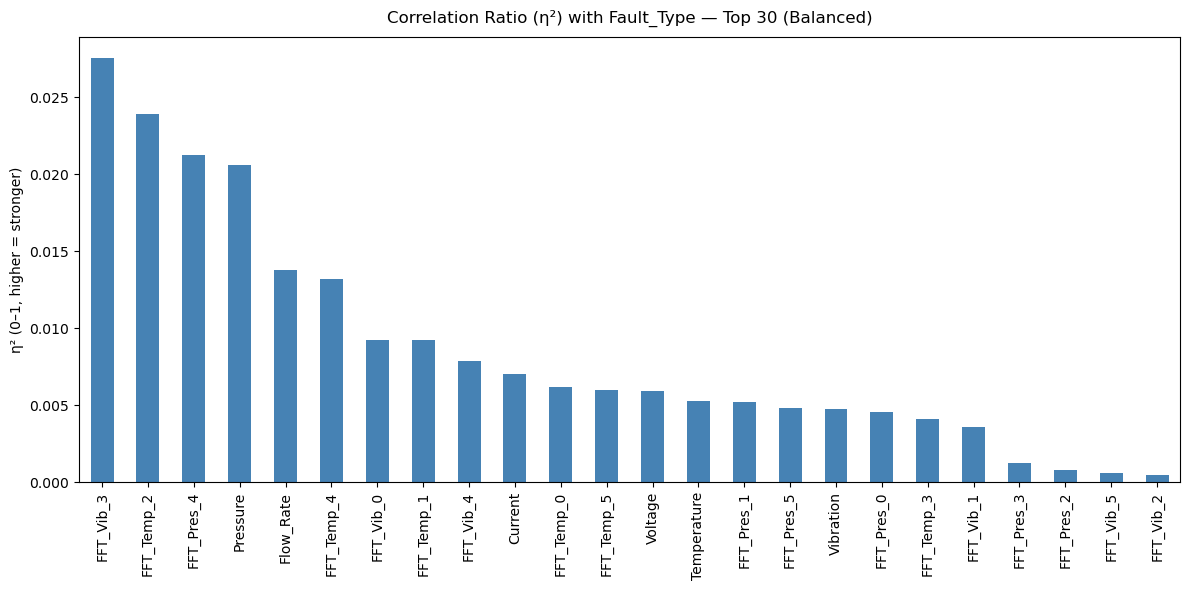

Top features by η²:
 FFT_Vib_3      0.027549
FFT_Temp_2     0.023933
FFT_Pres_4     0.021262
Pressure       0.020623
Flow_Rate      0.013805
FFT_Temp_4     0.013164
FFT_Vib_0      0.009247
FFT_Temp_1     0.009232
FFT_Vib_4      0.007839
Current        0.007024
FFT_Temp_0     0.006197
FFT_Temp_5     0.005986
Voltage        0.005897
Temperature    0.005236
FFT_Pres_1     0.005216
FFT_Pres_5     0.004803
Vibration      0.004729
FFT_Pres_0     0.004549
FFT_Temp_3     0.004071
FFT_Vib_1      0.003553
dtype: float64


In [292]:

scores_eta = {col: correlation_ratio(y_train, X_train_red[col])
              for col in X_train_red.columns}
eta_series = pd.Series(scores_eta).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
eta_series.head(30).plot(kind='bar', color='steelblue')
plt.title('Correlation Ratio (η²) with Fault_Type — Top 30 (Balanced)', pad=10)
plt.ylabel('η² (0–1, higher = stronger)')
plt.tight_layout()
plt.show()

print("Top features by η²:\n", eta_series.head(20))


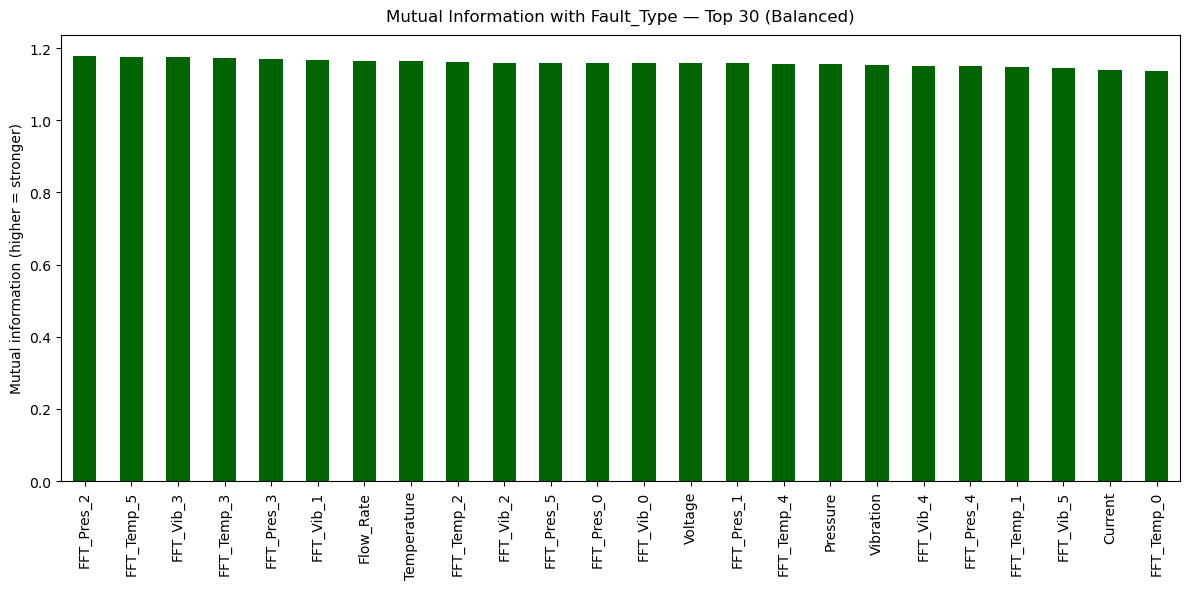

Top features by MI:
 FFT_Pres_2     1.177588
FFT_Temp_5     1.175672
FFT_Vib_3      1.174596
FFT_Temp_3     1.173082
FFT_Pres_3     1.168505
FFT_Vib_1      1.166734
Flow_Rate      1.165253
Temperature    1.163115
FFT_Temp_2     1.162386
FFT_Vib_2      1.159740
FFT_Pres_5     1.159125
FFT_Pres_0     1.159030
FFT_Vib_0      1.158619
Voltage        1.158372
FFT_Pres_1     1.158083
FFT_Temp_4     1.155864
Pressure       1.155767
Vibration      1.152446
FFT_Vib_4      1.151581
FFT_Pres_4     1.150930
dtype: float64


In [293]:

mi = mutual_info_classif(X_train_red.values, y_train,
                         random_state=42, discrete_features=False)
mi_series = pd.Series(mi, index=X_train_red.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
mi_series.head(30).plot(kind='bar', color='darkgreen')
plt.title('Mutual Information with Fault_Type — Top 30 (Balanced)', pad=10)
plt.ylabel('Mutual information (higher = stronger)')
plt.tight_layout()
plt.show()

print("Top features by MI:\n", mi_series.head(20))


In [ ]:

pipe_nb_pca = Pipeline([
    ('power', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=42)),
    ('clf', GaussianNB())
])

param_grid_nb_pca = {
    # try retaining 90–99.9% variance or a fixed #components
    'pca__n_components': [0.90, 0.95, 0.98, 0.99, 20, 24, 28],
    'clf__var_smoothing': np.logspace(0, -9, 15)
}

grid_nb_pca = GridSearchCV(
    pipe_nb_pca,
    param_grid=param_grid_nb_pca,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)
grid_nb_pca.fit(X_train_red, y_train)

print("NB+PCA — Best params:", grid_nb_pca.best_params_)
print("NB+PCA — CV macro F1:", grid_nb_pca.best_score_)

# Test (remember to drop the same redundant columns)
X_test_red = X_test.select_dtypes(include=[np.number]).drop(columns=to_drop)
y_pred_nb_pca = grid_nb_pca.best_estimator_.predict(X_test_red)
print(classification_report(y_test, y_pred_nb_pca, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb_pca))


NB+PCA — Best params: {'clf__var_smoothing': np.float64(0.0517947467923121), 'pca__n_components': 0.99}
NB+PCA — CV macro F1: 0.4688105799636994
              precision    recall  f1-score   support

           0      0.649     0.336     0.442       143
           1      0.065     0.167     0.094        18
           2      0.098     0.211     0.133        19
           3      0.027     0.056     0.036        18

    accuracy                          0.283       198
   macro avg      0.210     0.192     0.176       198
weighted avg      0.486     0.283     0.344       198



c:\Users\E1012131\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
75 fits failed out of a total of 525.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\E1012131\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\E1012131\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\E1012131\AppData\Local\anaconda3\Lib\site-packages

In [296]:

pipe_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('select', SelectFromModel(
        RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1),
        threshold='median'    # keep features above median importance
    )),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid_rf = {
    'select__estimator__n_estimators': [300, 400],
    'select__threshold': ['median', 'mean', 0.001],    # tune selection strictness
    'clf__n_estimators': [400, 600],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

grid_rf.fit(X_train_red, y_train)

print("RF — Best params:", grid_rf.best_params_)
print("RF — Best CV score (macro F1):", grid_rf.best_score_)

best_rf = grid_rf.best_estimator_

# Predict on test with same redundancy drop applied
X_test_red = X_test.select_dtypes(include=[np.number]).drop(columns=to_drop)
y_pred_rf = best_rf.predict(X_test_red)

print("\nRF — Test classification report:")
print(classification_report(y_test, y_pred_rf, digits=3))

cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(cm_rf)
disp_rf.plot(cmap='Greens')
plt.title('Confusion Matrix — Random Forest (balanced + selected)')
plt.show()

# Feature names kept by SelectFromModel:
sel_rf = best_rf.named_steps['select']
rf_est_for_sel = sel_rf.estimator_
mask_rf = sel_rf.get_support()
selected_rf = X_train_red.columns[mask_rf].tolist()
print("RF — Selected features:", selected_rf)

# Optional: visualize RF importances from the selector stage
imp = pd.Series(rf_est_for_sel.feature_importances_, index=X_train_red.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 5))
imp.head(20).plot(kind='bar', color='orange')
plt.title('RF Selection Stage — Feature Importances (top 20)')
plt.ylabel('Importance')
plt.tight_layout()


KeyboardInterrupt: 